In [24]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# matplotlib.use('Agg')  # noqa: E402

In [25]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y", dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
                   obs=Y)


# helper function for doing hmc inference
def run_inference(model, args, rng_key, X, Y):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(kernel, args.num_warmup, args.num_samples, num_chains=args.num_chains,
                progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()
    print('\nMCMC elapsed time:', time.time() - start)
    return mcmc.get_samples()


# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.)) * jax.random.normal(rng_key, X_test.shape[:1])
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise


# create artificial regression dataset
def get_data(N=30, sigma_obs=0.15, N_test=400):
    np.random.seed(0)
    X = jnp.linspace(-1, 1, N)
    Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
    Y += sigma_obs * np.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N,)
    assert Y.shape == (N,)

    X_test = jnp.linspace(-1.3, 1.3, N_test)

    return X, Y, X_test

In [26]:
assert numpyro.__version__.startswith('0.4.1')

class Args:
    num_chains = 1
    num_samples = 1000
    num_warmup = 1000
    num_data = 25
    device = 'cpu' #'gpu'

args = Args()

numpyro.set_platform(args.device)
numpyro.set_host_device_count(args.num_chains)


X, Y, X_test = get_data(N=args.num_data)

# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model, args, rng_key, X, Y)

sample: 100%|██████████| 2000/2000 [00:06<00:00, 294.26it/s, 7 steps of size 4.98e-01. acc. prob=0.93]

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.69      0.23      0.66      0.36      1.03    504.28      1.00
   kernel_noise      0.06      0.02      0.06      0.03      0.09    563.34      1.00
     kernel_var      3.19      8.80      1.37      0.17      5.85    663.05      1.00

Number of divergences: 0

MCMC elapsed time: 6.9314188957214355


In [27]:
# do prediction
vmap_args = (random.split(rng_key_predict, args.num_samples * args.num_chains), samples['kernel_var'],
                samples['kernel_length'], samples['kernel_noise'])
means, predictions = vmap(lambda rng_key, var, length, noise: predict(rng_key, X, Y, X_test, var, length, noise))(*vmap_args)

mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

In [41]:
# kernel(X,X,samples['kernel_var'],samples['kernel_length'],samples['kernel_noise'])
(random.split(rng_key_predict, args.num_samples * args.num_chains), samples['kernel_var'], samples['kernel_length'], samples['kernel_noise'])

4

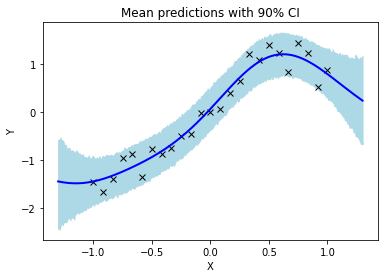

In [4]:
# make plots
fig, ax = plt.subplots()

# plot training data
ax.plot(X, Y, 'kx')
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color='lightblue')
# plot mean prediction
ax.plot(X_test, mean_prediction, 'blue', ls='solid', lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")

plt.show()

In [16]:
fig, ax = plt.subplots()

plt.show()

# Try our own

In [1]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import pandas as pd
import datetime as dt
# matplotlib.use('Agg')  # noqa: E402

In [2]:
bd = pd.read_csv('./birthdays.txt')

lam_date_join = lambda row: f"{row['year']}-{row['month']}-{row['day']}"
bd["date"] = pd.to_datetime(bd.apply(lam_date_join, axis=1), format="%Y-%m-%d")
lam_get_day = lambda date: date.days

bd_sm = bd[bd["year"] <= 1970]
bd_sm['date_indexed'] = (bd_sm['date'] - bd_sm['date'].min()).apply(lam_get_day)
bd_sm['date_normed'] = (bd_sm['date_indexed'] - bd_sm['date_indexed'].mean()) / bd_sm['date_indexed'].std()

In [3]:
# fig, ax = plt.subplots(nrows=2, figsize=(10,10))
# ax[0].scatter(bd["date"], bd["births"], s=2, alpha=0.3, color='g')
# # ax[1].scatter(bd_sm["date"], bd_sm["births"], s=2, alpha=0.3, color='g')
# ax[1].scatter(bd_sm["date_normed"], bd_sm["births"], s=2, alpha=0.3, color='g')
# plt.show()

In [4]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y", dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
                   obs=Y)


# helper function for doing hmc inference
def run_inference(model, args, rng_key, X, Y):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(kernel, args.num_warmup, args.num_samples, num_chains=args.num_chains,
                progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()
    print('\nMCMC elapsed time:', time.time() - start)
    return mcmc.get_samples()


# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.)) * jax.random.normal(rng_key, X_test.shape[:1])
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise


# create artificial regression dataset
def get_data(N=30, sigma_obs=0.15, N_test=400):
    np.random.seed(0)
    X = jnp.linspace(-1, 1, N)
    Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
    Y += sigma_obs * np.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N,)
    assert Y.shape == (N,)

    X_test = jnp.linspace(-1.3, 1.3, N_test)

    return X, Y, X_test

In [6]:
N_train = int(bd_sm.shape[0]*0.8)
X = bd_sm["date_normed"].values 
X_test = jnp.asarray(X[N_train:])
X = jnp.asarray(X[:N_train])
Y = jnp.asarray(bd_sm["births"].values[:N_train])

class Args:
    num_chains = 1
    num_samples = 1_000
    num_warmup = 1_000
    # num_data = 25
    device = 'cpu' #'gpu'

args = Args()

numpyro.set_platform(args.device)
numpyro.set_host_device_count(args.num_chains)


# X, Y, X_test = get_data(N=args.num_data)

# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model, args, rng_key, X, Y)

sample: 100%|██████████| 2000/2000 [01:48<00:00, 18.40it/s, 7 steps of size 6.88e-01. acc. prob=0.90]

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.58      0.05      0.58      0.51      0.67    708.21      1.00
   kernel_noise 466011.00  26551.19 464912.03 425476.56 509266.16    797.63      1.01
     kernel_var 69447728.00 48087180.00 55458568.00 17726864.00 124136976.00    511.33      1.00

Number of divergences: 0

MCMC elapsed time: 109.9621810913086


In [13]:
# do prediction

# vmap_args = (random.split(rng_key_predict, args.num_samples * args.num_chains), samples['kernel_var'],
vmap_args = (random.split(rng_key_predict, 1_000 * 1), samples['kernel_var'], samples['kernel_length'], samples['kernel_noise'])
means, predictions = vmap(lambda rng_key, var, length, noise: predict(rng_key, X, Y, X_test, var, length, noise))(*vmap_args)

mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

RuntimeError: Invalid argument: The rank of the operand and the padding configuration do not match: f32[56,56] vs dimensions { } dimensions { edge_padding_low: 72 } dimensions { }.: 

In [ ]:
get_data(N=30,)

In [8]:
X

DeviceArray([-1.7284946 , -1.7237525 , -1.7190105 , -1.7142683 ,
             -1.7095263 , -1.7047842 , -1.700042  , -1.6953    ,
             -1.6905578 , -1.6858158 , -1.6810737 , -1.6763315 ,
             -1.6715895 , -1.6668473 , -1.6621053 , -1.6573632 ,
             -1.652621  , -1.647879  , -1.6431369 , -1.6383948 ,
             -1.6336527 , -1.6289105 , -1.6241685 , -1.6194264 ,
             -1.6146843 , -1.6099422 , -1.6052    , -1.600458  ,
             -1.5957159 , -1.5909739 , -1.5862317 , -1.5814896 ,
             -1.5767475 , -1.5720054 , -1.5672634 , -1.5625212 ,
             -1.5577791 , -1.553037  , -1.5482949 , -1.5435529 ,
             -1.5388107 , -1.5340686 , -1.5293266 , -1.5245844 ,
             -1.5198424 , -1.5151002 , -1.5103581 , -1.5056161 ,
             -1.5008739 , -1.4961319 , -1.4913898 , -1.4866476 ,
             -1.4819056 , -1.4771634 , -1.4724214 , -1.4676793 ,
             -1.4629371 , -1.4581951 , -1.453453  , -1.4487109 ,
             -1.4439688 ,

In [14]:
x,y, x_test = get_data(N=25)

In [23]:
x_test.shape

(400,)

In [22]:
X_test.shape

(146,)